# Lab Assignment 2.1

**Submission deadline:**
* **lab session in the week 22-27.11.20**

**Points: 18 points**

The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [ ]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm

import graphviz
import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# Problem 1 [3p] Ridge Regression

In this problem you will implement ridge regression **without using `sklearn`**!

When the data set is small and highly dimensional (or when high degree polynomials are used) the linear regression solution may fit the noise in the data instead of capturing the general rule. We call this phenomenon overfitting and will discuss it in detail in a few lectures.

One way of preventing overfitting is to force the model's parameters to be small. We call this *regularization*. Consider the following cost function:

$$ J(\Theta) = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2 + \frac{\alpha}{N} \Theta^T \Theta $$

Analyze datasets sampled using the following procedure:

1. $x \propto U(0;1)$: first $x$ is sampled uniformly from the  $0-1$ range.
2. $y \propto \mathcal{N}(\mu=1+2x-5x^2 + 4x^3, \sigma=0.1)$: then 
    $y$ is sampled from the Normal distribution with mean 
    $\mu=1+2x-5x^2+4x^3$ and standard deviation $0.1$


## Task 1.1 [1.5p]
Repeat 30 times an experiment in which you sample a new training
dataset, then fit polynomials of degree 0 to 14 and use $\alpha$
value from the set $\{0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}\}$.

Plot the mean training and testing errors. What is the effect of increasing $\alpha$?

Plot how the error rates depend on the the polynomial degree and regularization constant. Try to find the best value for alpha on the test set, **explain** the model behavoir for small alphas and large alphas.

## Task 1.2 [0.5p]
Use a small alpha for numerical stability (1e-6) and train the model on increasingly large training sets. Plot the training curves (train and test error rates versus amount of training data). What can you notice?

## Task 1.3 [1p]

Now let's change the data slightly:
1. $x \propto U(0;10)$
2. $y \propto \mathcal{N}(\mu=1+0.2x-0.05x^2 + 0.004x^3, \sigma=0.1)$

Try fitting the polynomial regression once again. Would it make sense to normalize the data after feature expansion?

Which dataset is easier to fit? When is ridge regression most effective? 

Note: in real life, we may e.g. have a dataset with mixed units, like milimeters and kilometers. Data normalization is often an important preprocessing step.


## Task 1.1

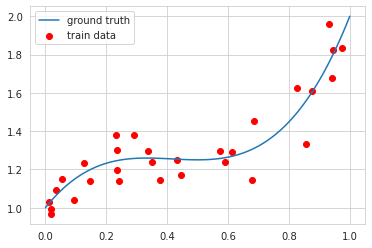

In [ ]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#
# TODO: write down the proper coefficients
#


def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(1, -1)
    return X ** powers


def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1)  # len(Theta) x N
    Y = XP @ Theta
    return Y


true_poly_theta = np.array(
    [1.0, 2.0, -5, 4])


def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.uniform(size=(N, 1))
    Y_clean = compute_polynomial(X, theta.reshape(-1,1))
    Y = Y_clean + np.random.randn(N, 1) * sigma
    return X, Y


train_data = make_dataset(30)
XX = np.linspace(0, 1, 100).reshape(-1, 1)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.legend(loc="upper left")

In [ ]:
def poly_fit(data, degree, alpha):
    "Fit a polynomial of a given degree and weight decay parameter alpha"
    X = powers_of_X(data[0], degree)  # Matrix N x d
    Y = data[1].reshape(-1, 1)  # Matrix N x 1
    #
    # TODO: implement the closed-form solution for Theta
    #
    # Please note that np.linalg.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    #
    Theta = np.linalg.solve(X.T @ X + 2 * alpha * np.identity(degree + 1), X.T @ Y) 
    return Theta

In [ ]:
num_test_samples = 100
num_train_samples = [30]
alphas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30


# sample a single test dataset for all experiments
test_data = make_dataset(num_test_samples)
results = []

for (repetition, num_train, alpha, degree,) in itertools.product(
    range(num_repetitions), num_train_samples, alphas, degrees
):
    train_data = make_dataset(num_train)
    X_train = powers_of_X(train_data[0], degree)
    Y_train = train_data[1]
    X_test = powers_of_X(test_data[0], degree)
    Y_test = test_data[1]

    Theta = poly_fit(train_data, degree, alpha)
    train_err = (1 / num_train) * ((X_train @ Theta - Y_train).T @ (X_train @ Theta - Y_train))[0,0]
    test_err = (1 / num_test_samples) * ((X_test @ Theta - Y_test).T @ (X_test @ Theta - Y_test))[0,0]
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": str(alpha),
            "degree": degree,
            "dataset": "train",
            "err_rate": train_err,
        }
    )
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": str(alpha),
            "degree": degree,
            "dataset": "test",
            "err_rate": test_err,
        }
    )
results_df = pd.DataFrame(results)
results_df

repetition  num_train alpha  degree dataset  err_rate
0              0         30   0.0       0   train  0.041513
1              0         30   0.0       0    test  0.061461
2              0         30   0.0       1   train  0.019261
3              0         30   0.0       1    test  0.023355
4              0         30   0.0       2   train  0.016364
...          ...        ...   ...     ...     ...       ...
7195          29         30   1.0      12    test  0.022851
7196          29         30   1.0      13   train  0.019713
7197          29         30   1.0      13    test  0.021193
7198          29         30   1.0      14   train  0.017258
7199          29         30   1.0      14    test  0.018859

[7200 rows x 6 columns]

(0.0, 0.1)

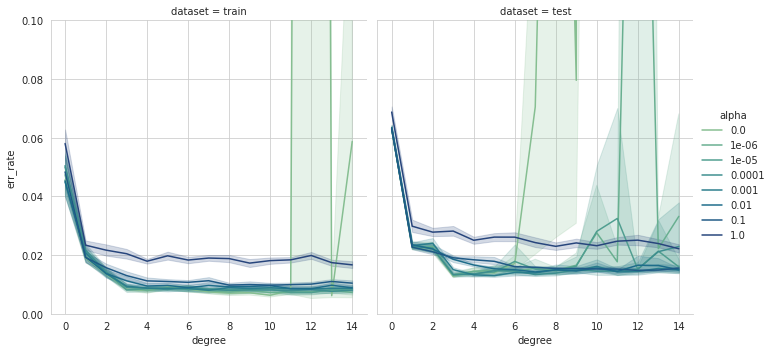

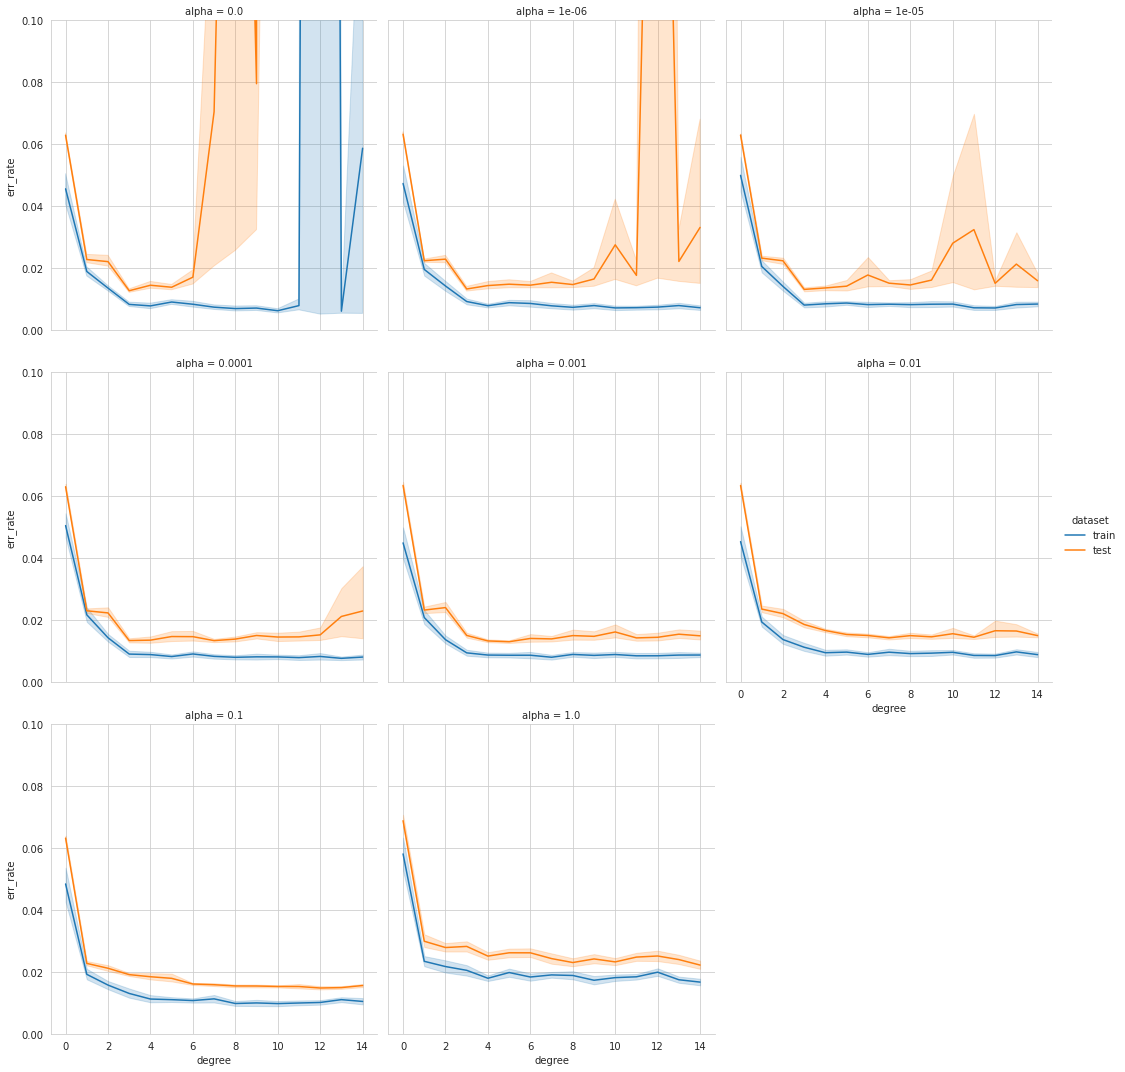

In [ ]:
# TODO
#
# Plot how the error rates depend on the the polynomial degree and regularization
# constant.
# Try to find the best value for lambda on the test set, explain the model
# behavoir for small lambdas and large lambdas.
#
# Hint: the plots below all use sns.relplot!
#

sns.relplot(data = results_df, x = 'degree', y = 'err_rate', col = 'dataset', hue = 'alpha', palette = 'crest', kind = 'line')
plt.ylim((0,0.10))
sns.relplot(data = results_df, x = 'degree', y = 'err_rate', col = 'alpha', hue = 'dataset', col_wrap = 3, kind = 'line')
plt.ylim((0,0.10))


**TODO**
Wraz ze wzrostem alpha błędy są coraz mniejsze
 
Małe alpha:
współczynnik regularyzacji jest zerowy lub bardzo mały - funkcja jeszcze bardziej przykleja sie do danych treningowych i na tescie sobie nie radzi. Dla małego alpha nawet na zbiorze treningowym są problemy - przez względy numeryczne.

Duże alpha:
współczynnik regularyzacji jest duży i nie ma za bardzo overfittingu, osiąga się zbliżone rezultaty na teście i treningu



## Task 1.2

In [ ]:
# TODO
# Now set a small regularizatoin for numerical stability  (e.g. alpha=1e-6)
# and present the relationship between
# train and test error rates for varous degrees of the polynomial for
# different sizes of the train set.
#
num_test_samples = 100
num_train_samples = np.logspace(1,3,num = 100)
alphas = [0.000001]
degrees = range(15)
num_repetitions = 30


# sample a single test dataset for all experiments
test_data = make_dataset(num_test_samples)
results = []

for (repetition, num_train, alpha, degree,) in itertools.product(
    range(num_repetitions), num_train_samples, alphas, degrees
):
    train_data = make_dataset(int(num_train))
    X_train = powers_of_X(train_data[0], degree)
    Y_train = train_data[1]
    X_test = powers_of_X(test_data[0], degree)
    Y_test = test_data[1]

    Theta = poly_fit(train_data, degree, alpha)
    train_err = (1 / num_train) * ((X_train @ Theta - Y_train).T @ (X_train @ Theta - Y_train))[0,0]
    test_err = (1 / num_test_samples) * ((X_test @ Theta - Y_test).T @ (X_test @ Theta - Y_test))[0,0]
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": str(alpha),
            "degree": degree,
            "dataset": "train",
            "err_rate": train_err,
        }
    )
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": str(alpha),
            "degree": degree,
            "dataset": "test",
            "err_rate": test_err,
        }
    )
results_df2 = pd.DataFrame(results)
results_df2


repetition  num_train  alpha  degree dataset  err_rate
0               0       10.0  1e-06       0   train  0.028207
1               0       10.0  1e-06       0    test  0.057174
2               0       10.0  1e-06       1   train  0.009896
3               0       10.0  1e-06       1    test  0.020886
4               0       10.0  1e-06       2   train  0.012040
...           ...        ...    ...     ...     ...       ...
89995          29     1000.0  1e-06      12    test  0.008937
89996          29     1000.0  1e-06      13   train  0.009982
89997          29     1000.0  1e-06      13    test  0.008757
89998          29     1000.0  1e-06      14   train  0.009694
89999          29     1000.0  1e-06      14    test  0.008959

[90000 rows x 6 columns]

(0.0, 0.1)

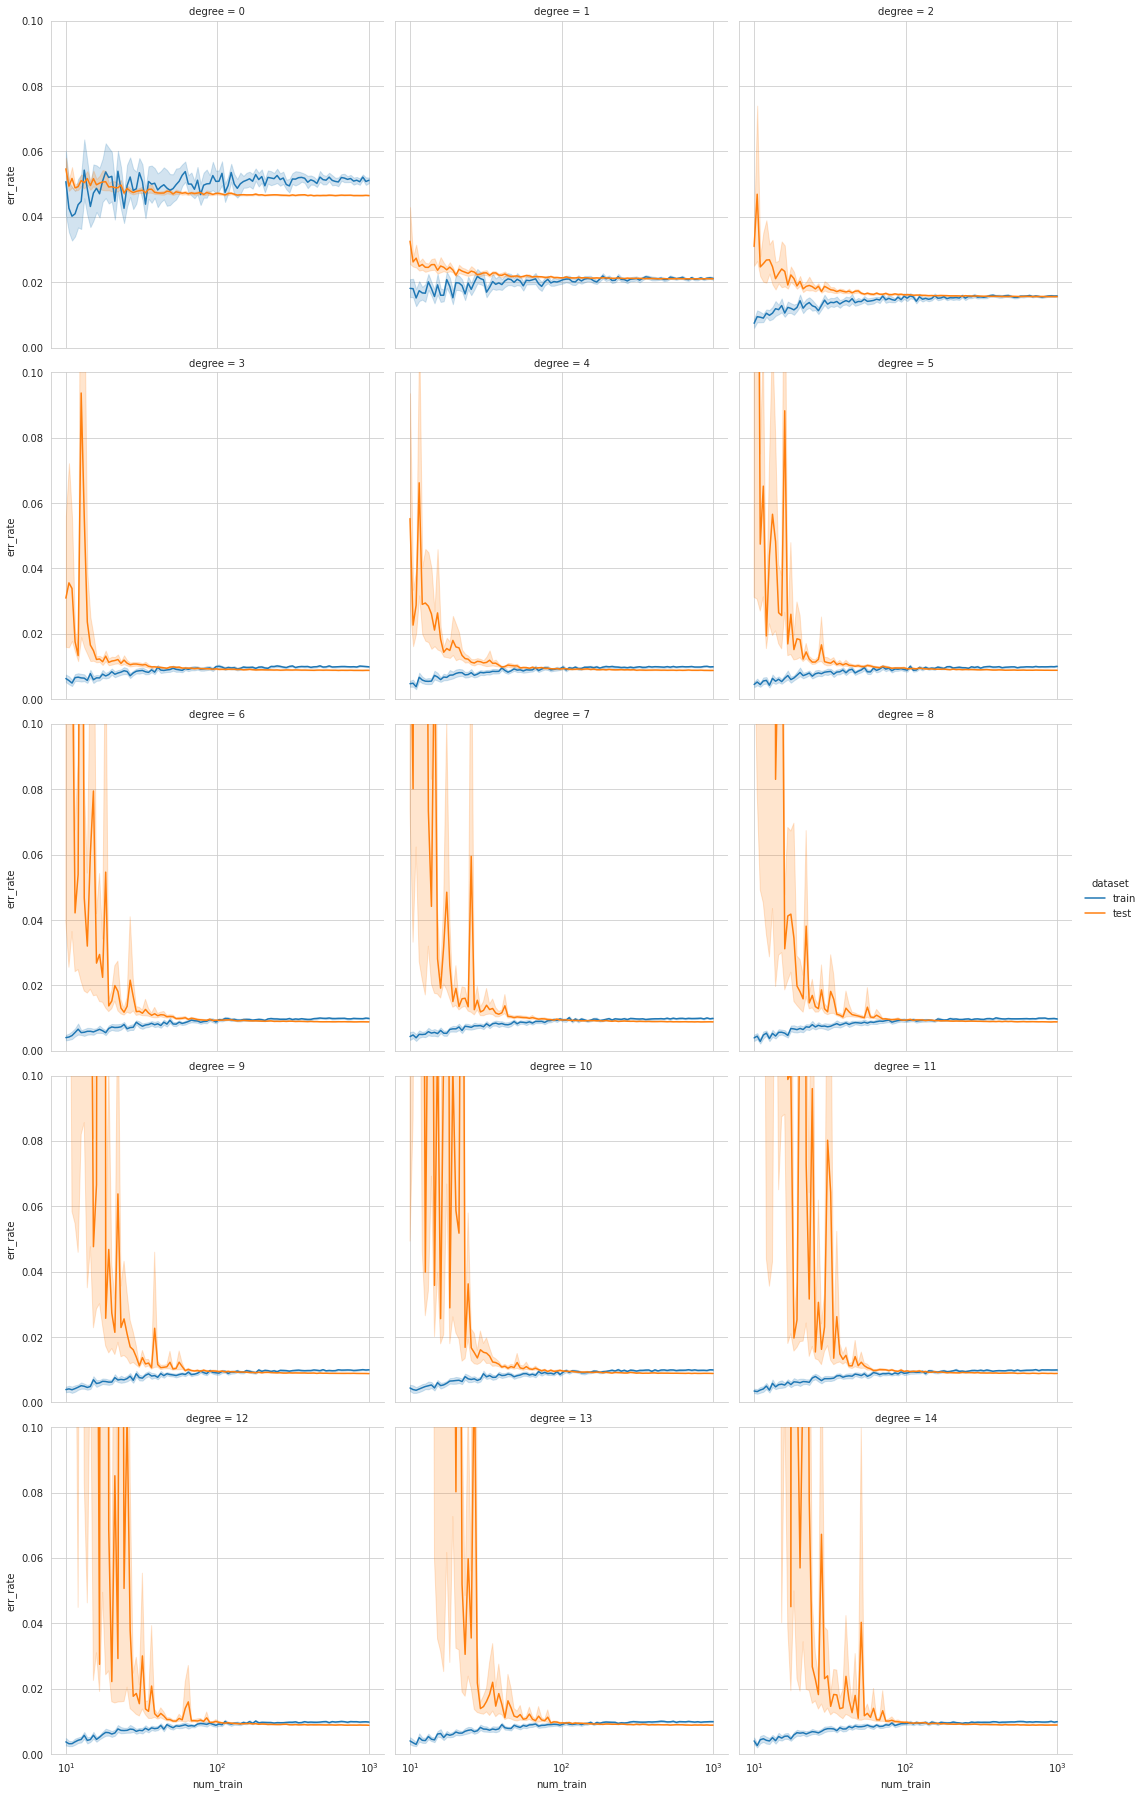

In [ ]:
p = sns.relplot(data = results_df2, x = 'num_train', y = 'err_rate', col = 'degree', hue = 'dataset', col_wrap = 3, kind = 'line')
p.set(xscale='log')
plt.ylim((0,0.10))

**TODO** Describe in two sentences the plot above. What can you notice?

Wraz ze wzrostem wielkości zbioru treningowego, błędy na zbiorze testowym są coraz bardziej zbliżone do błędów na zbiorze treningowym. Można zauważyć, że spory zbiór treningowy ma na tyle dużo "szumów", że wielomian nawet stopnia 14. nie powoduje overfittingu. Brak "przyklejania" się do szumu można zauważyć we wzroście błędów na testach treningowych.

## Task 1.3



In [ ]:
true_poly_theta = np.array(
    [1.0, 0.2, -0.05, 0.004])

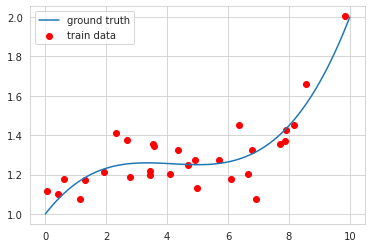

In [ ]:
def make_dataset2(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.uniform(size=(N, 1), high = 10.0)
    Y_clean = compute_polynomial(X, theta.reshape(-1,1))
    Y = Y_clean + np.random.randn(N, 1) * sigma
    return X, Y

train_data = make_dataset2(30, theta = true_poly_theta)
XX = np.linspace(0, 10, 100).reshape(-1, 1)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.legend(loc="upper left")

In [ ]:
num_test_samples = 100
num_train_samples = [30]
alphas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
degrees = range(15)
num_repetitions = 30


# sample a single test dataset for all experiments
test_data = make_dataset2(num_test_samples, theta = true_poly_theta)
results = []

for (repetition, num_train, alpha, degree,) in itertools.product(
    range(num_repetitions), num_train_samples, alphas, degrees
):
    train_data = make_dataset2(num_train, theta = true_poly_theta)
    X_train = powers_of_X(train_data[0], degree)
    Y_train = train_data[1]
    X_test = powers_of_X(test_data[0], degree)
    Y_test = test_data[1]

    Theta = poly_fit(train_data, degree, alpha)
    train_err = (1 / num_train) * ((X_train @ Theta - Y_train).T @ (X_train @ Theta - Y_train))[0,0]
    test_err = (1 / num_test_samples) * ((X_test @ Theta - Y_test).T @ (X_test @ Theta - Y_test))[0,0]
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": str(alpha),
            "degree": degree,
            "dataset": "train",
            "err_rate": train_err,
        }
    )
    results.append(
        {
            "repetition": repetition,
            "num_train": num_train,
            "alpha": str(alpha),
            "degree": degree,
            "dataset": "test",
            "err_rate": test_err,
        }
    )
results_df3 = pd.DataFrame(results)
results_df3

repetition  num_train alpha  degree dataset  err_rate
0              0         30   0.0       0   train  0.053296
1              0         30   0.0       0    test  0.038947
2              0         30   0.0       1   train  0.011416
3              0         30   0.0       1    test  0.017793
4              0         30   0.0       2   train  0.012752
...          ...        ...   ...     ...     ...       ...
7195          29         30   1.0      12    test  0.528565
7196          29         30   1.0      13   train  0.020425
7197          29         30   1.0      13    test  0.022046
7198          29         30   1.0      14   train  0.017426
7199          29         30   1.0      14    test  0.023371

[7200 rows x 6 columns]

(0.0, 0.1)

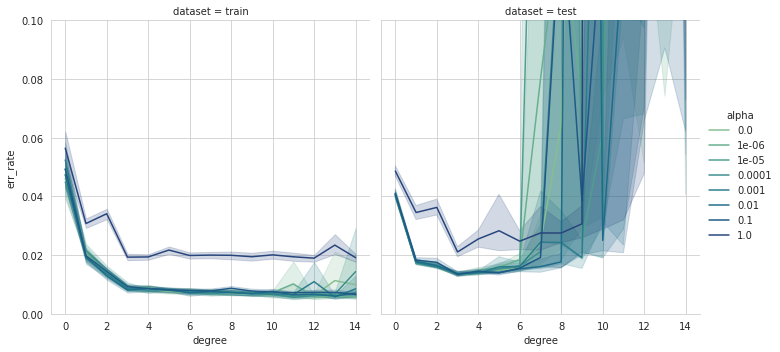

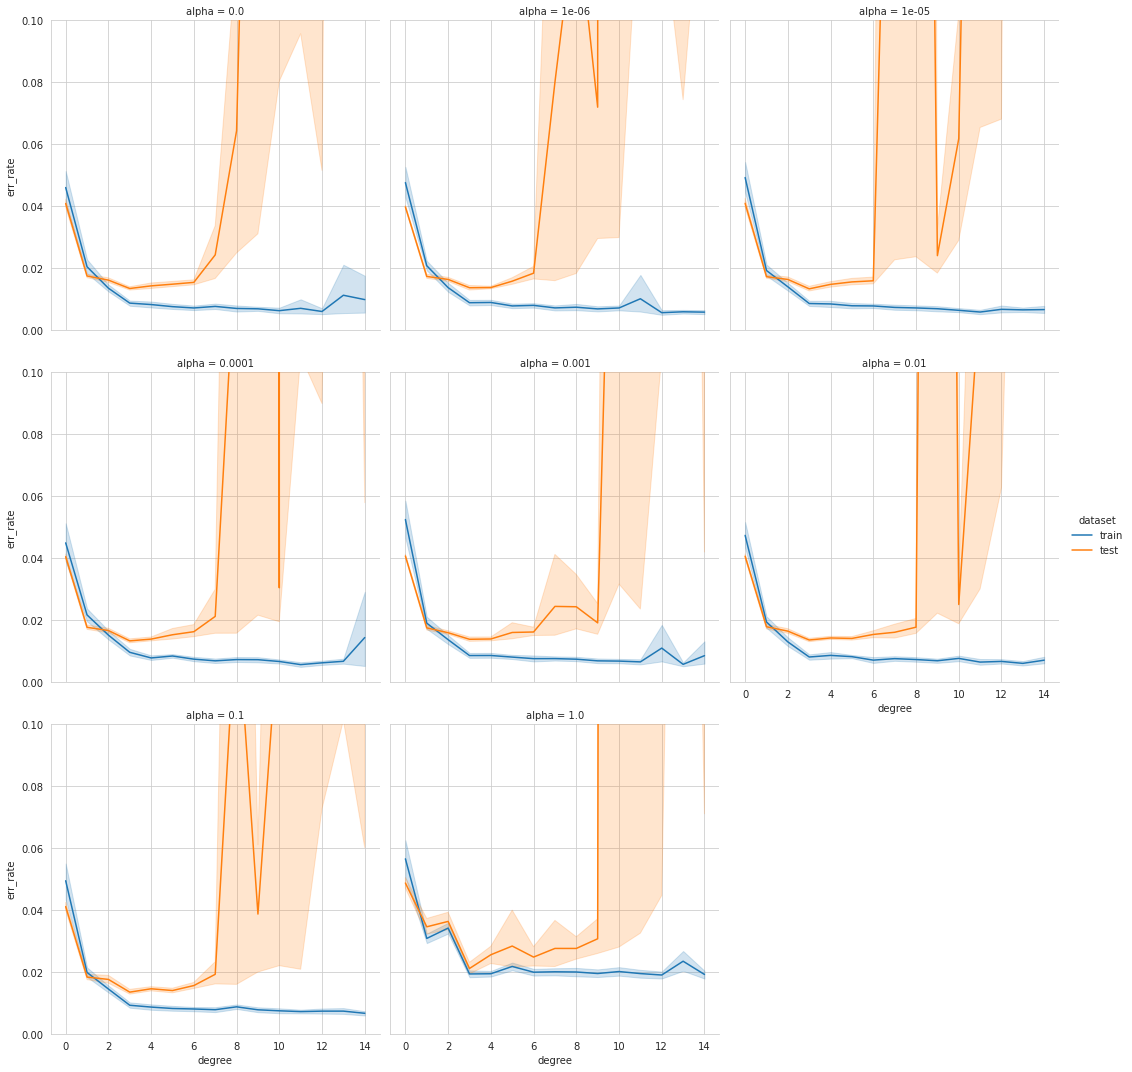

In [ ]:
sns.relplot(data = results_df3, x = 'degree', y = 'err_rate', col = 'dataset', hue = 'alpha', palette = 'crest', kind = 'line')
plt.ylim((0,0.10))
sns.relplot(data = results_df3, x = 'degree', y = 'err_rate', col = 'alpha', hue = 'dataset', col_wrap = 3, kind = 'line')
plt.ylim((0,0.10))

**TODO** Answer below the questions:

Would it make sense to normalize the data after feature expansion?

Tak. Po zmienieniu funkcji mamy do czynienia z danymi, które na y różnią sie o około 1, na x różnią sie o 10. Przez to aby zmienić lekko y, musimy posunąć się stosunkowo dużo na x. Współczynniki Thety będą zatem mniejsze niż w poprzednim wypadku. W naszej funkcie straty (loss) współczynnik regularyzacji nie będzie odgrywać takiej dużej roli (w porównaniu do MSE) i regresja przyklei nam funkcję do szumów. (w poprzednim datasecie aby funkcja się przykleiła, współczynniki Thety musiały być znacznie większe niż współczynniki Thety na aktualnym datasecie - jest to spowodowane duża wariancją x i mała y)

Which dataset is easier to fit?

Poprzedni czyli znormalizowany. W tym datatsecie wystepuje zjawisko overfittingu.

When is ridge regression most effective?

Gdy mamy do czynienia ze znormalizowanymi danymi - wtedy działa regularyzacja i nie występuje overfitting.


# Problem 2 (Logistic Regression) [2p]

Linear regression is suitable for problems, where
the forecasted values are real numbers. We use logistic regression,
when we want to label the data with $0$ and $1$.

Let $x\in \mathbb{R}^n$ be a row vector of $n$ real numbers, and
$y\in \{0,1\}$ the given class label. Similarly to what was shown
during the lecture, we add an additional element $x_0=1$
to vector $x$, to account for the bias term (and simplify the equations).

Similarly to linear regression, vector
$\Theta\in \mathbb{R}^{n+1}$ parametrizes the model
($n$ coefficients describes the data, the remaining one is the intercept).
In logistic regression, we model conditional probability that
sample $x$ belongs to class $1$ as:

\begin{equation}
p(\text{class}=1|x, \Theta)=h_\Theta(x) = \sigma\left(\sum_{j=0}^n  x_j\Theta_j\right) 
= \sigma\left(x\Theta \right),
\end{equation}

where $\sigma(a) = \frac{1}{1+\exp(-a)}$ is being called the logistic sigmoid
(a function, which plot is s-curved).

An unknown sample $x$ is being labeled $1$ if
$h_\Theta(x)\geq 0.5$, or equivalently, $x\Theta \geq 0$.

Classification mismatch between the forecasted values and
the data is being measured most of the time with cross-entropy:

\begin{equation}
    J(\Theta) = - \sum_{i=1}^m y^{(i)} \log \left(h_\Theta (x^{(i)})\right) + (1-y^{(i)}) \log \left(1-h_\Theta (x^{(i)})\right),
\end{equation}

assuming $0\log(0)=0$.


## Task 2.1 [1p]
Use logistic regression to distinguish
  _Versicolor_ and _Virginica_ irises. Use only the
  `petal length` and `petal width` features. Use **L-BFGS** to solve for the optimal $\Theta$.
  Prepare the scatterplot of the data and plot the class separation
  boundary found by logistic regression.

## Task 2.2 [1p]
Use logistic regression to distinguish
  _Versicolor_ and _Virginica_ irises. Use only the
  `petal length` and `petal width` features. Use **Gradient Descent** to solve for the optimal $\Theta$.
  Prepare the scatterplot of the data and plot the class separation
  boundary found by logistic regression.

## Task 2.3 [1p]

In an analogy to Ridge Regression, implement a penalty on the weights of logistic regression. 

Then make a contour plot of the probability assigned by the model with no regularization $\alpha=0$ and with regularization, e.g. $\alpha=10^-2$ and $\alpha=1$. Describe what has changed?

## Task 2.1 solution

In [ ]:
iris = datasets.load_iris()
print("Features: ", iris.feature_names)
print("Targets: ", iris.target_names)
petal_length = iris.data[:, iris.feature_names.index("petal length (cm)")].reshape(-1, 1)
petal_width = iris.data[:, iris.feature_names.index("petal width (cm)")].reshape(-1, 1)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

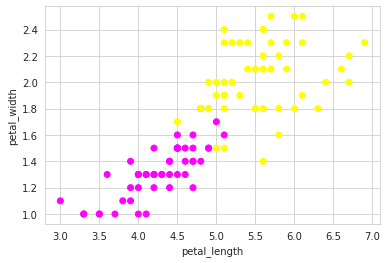

In [ ]:
# Extract the petal_length and petal_width of versicolors and virginicas

IrisX = np.hstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[iris.target != 0, :]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target != 0] - 1).reshape(-1, 1).astype(np.float64)

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

optimal theta: [-45.27237188   5.75453487  10.44670958]


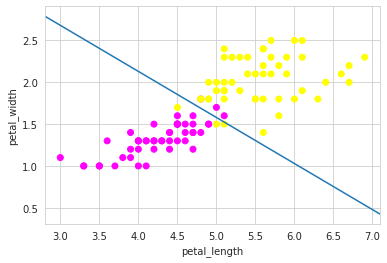

In [ ]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def logreg_loss(Theta, X, Y):
    #
    # Write a logistic regression cost suitable for use with fmin_l_bfgs
    #

    # reshape Theta into a column vector - lBFGS gives us a flat array
    ThetaR = Theta.reshape(X.shape[1], 1)

    A = X @ ThetaR
    nll = - np.sum(Y * np.log(sigmoid(A)) + (1.0 - Y) * np.log(1 - sigmoid(A)))
    grad = X.T @ (sigmoid(X @ ThetaR) - Y)

    # reshape grad into the shape of Theta, for fmin_l_bfsgb to work
    return nll, grad.reshape(Theta.shape)


Theta0 = np.zeros((3, ))

#
# Call a solver
#
ThetaOpt = sopt.fmin_l_bfgs_b(
    lambda Theta: logreg_loss(Theta, IrisX, IrisY), np.array(Theta0)
)[0]


#
# Now plot the found separation line
#

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
pl_min, pl_max = plt.xlim()
pl = np.linspace(pl_min, pl_max, 1000)
plt.plot(pl, -(ThetaOpt[0] + ThetaOpt[1] * pl) / ThetaOpt[2])
plt.xlim(pl_min, pl_max)
print(f'optimal theta: {ThetaOpt}')

## Task 2.2 solution

Gradient descent made 81528 steps
Theta is:  [-45.08388493   5.726315    10.4161067 ]


(2.805, 7.095000000000001)

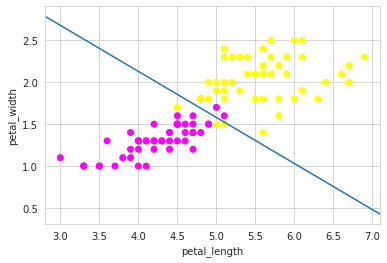

In [ ]:
def logreg_loss(Theta, X, Y):
    ThetaR = Theta.reshape(X.shape[1], 1)

    A = X @ ThetaR

    nll = - np.sum(Y * np.log(sigmoid(A)) + (1.0 - Y) * np.log(1 - sigmoid(A)))
    grad = X.T @ (sigmoid(X @ ThetaR) - Y)

    return nll, grad.reshape(Theta.shape)

def logreg(X, Y, alpha = 1e-2, stop_tolerance=1e-8, max_steps=1e5):

    history = []
    Theta = np.zeros((3, ))
    history.append(Theta)
    loss_act = logreg_loss(Theta, IrisX, IrisY)
    loss_bef = (loss_act[0] + 2 * stop_tolerance, None)
    it = 0
    #
    # in a loop perform the update Theta(t+1) = Theta(t) - lambda* d logreg_loss(Theta(t))/d Theta(t) 
    # until no significant change is possible
    #

    while abs(loss_bef[0] - loss_act[0]) > stop_tolerance and it < max_steps:
        
        Theta = Theta - alpha * loss_act[1]
        history.append(Theta)
        loss_bef = loss_act
        loss_act = logreg_loss(Theta, IrisX, IrisY)
        it += 1
    
    return Theta, history
    
ThetaOpt, history = logreg(IrisX, IrisY, alpha=1e-2, stop_tolerance=1e-8, max_steps=100000)
print(f"Gradient descent made {len(history)} steps")
print("Theta is: ", ThetaOpt)

#
# Now plot the found separation line
#

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
pl_min, pl_max = plt.xlim()
pl = np.linspace(pl_min, pl_max, 1000)
plt.plot(pl, -(ThetaOpt[0] + ThetaOpt[1] * pl) / ThetaOpt[2])
plt.xlim(pl_min, pl_max)

In [ ]:
# Make an animation of training
# code from lecture
from matplotlib import animation, rc
fig = plt.figure()
ax = plt.axes()
ax.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

xlim = np.array(plt.xlim())
ylim = plt.ylim()

line, = plt.plot([],[])

plt.close()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    epoch = 1 + int(1.0 * (len(history)-1) / num_frames * i)
    Theta = history[epoch]
    ax.set_title('Epoch %d, Theta: %s' % (epoch, Theta,))
    yy = (Theta[0] + xlim * Theta[1]) / - Theta[2]
    line.set_data(xlim, yy)
    return line,

num_frames=100
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)
rc('animation', html='jshtml')
anim

## Task 2.3 solution

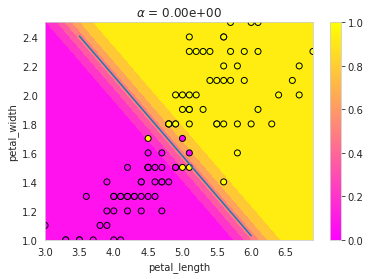

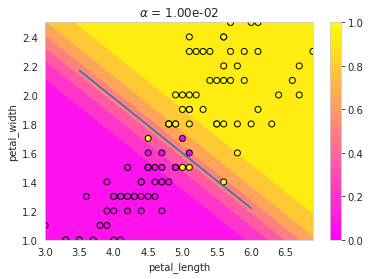

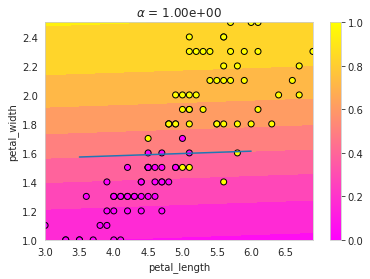

In [ ]:
# Change logistic regression to include a weight penalty term as in ridge regression
# Then plot the probabilities for different values of alpha
# Hint: use the contour plot code from Assignent 1
alphas = [0, 1e-2, 1.0]

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def logreg_loss_with_reg(Theta, X, Y, alpha=0.):

    ThetaR = Theta.reshape(X.shape[1], 1)

    A = X @ ThetaR

    nll = - np.sum(Y * np.log(sigmoid(A)) + (1.0 - Y) * np.log(1 - sigmoid(A))) + alpha/2 * (ThetaR.T @ ThetaR)
    grad = X.T @ (sigmoid(X @ ThetaR) - Y) +  2.0/2 * alpha * ThetaR

    return nll, grad.reshape(Theta.shape)


mesh_x, mesh_y = np.meshgrid(
    np.linspace(IrisX[:, 1].min(), IrisX[:, 1].max(), 100),
    np.linspace(IrisX[:, 2].min(), IrisX[:, 2].max(), 100),
)
mesh_data = np.hstack([np.ones(mesh_x.reshape(-1, 1).shape), mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

for alpha in alphas:
  Theta0 = np.zeros((3, ))

  #
  # Call a solver
  #
  ThetaOpt, _, dic = sopt.fmin_l_bfgs_b(
      lambda Theta: logreg_loss_with_reg(Theta, IrisX, IrisY, alpha=alpha), np.array(Theta0)
  )
  #n_iter.append(dic['nit'])

  #
  # Now calculate probabilities for mesh_data
  #
  probs = sigmoid(mesh_data @ ThetaOpt)

  #
  # Plot the decision boundary
  #
  plt.contourf(mesh_x, mesh_y, probs.reshape(mesh_x.shape), cmap='spring')
  plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY.ravel(), cmap="spring", linewidths=1, edgecolors='black')
  plt.colorbar()
  plt.xlabel("petal_length")
  plt.ylabel("petal_width")

  pl = np.linspace(IrisX[:, 1].min() + 0.5, IrisX[:, 1].max() - 0.9, 100)
  plt.plot(pl, -(ThetaOpt[0] + ThetaOpt[1] * pl) / ThetaOpt[2])
  
  pl_min, pl_max = plt.xlim()
  plt.title(fr'$\alpha$ = {alpha:.2e}')
  plt.xlim(pl_min, pl_max)
  plt.show()

**TODO**: type here what has changed with the change of $\alpha$.

Wraz ze wzrostem alpha zmienia się kąt prostej oddzielającej dwie klasy oraz prawdopodobieństwa rozkładają się nie tak skrajnie - tzn. w okolicach prostej regresji mamy spory obszar, gdzie prawdopodobieństwo danej klasy nie wynosi od razu 100%, tylko 50% - 70%. Jest to spowodowane tym, że współczynniki Thety są małe przez duży współczynnik alpha - przez to sigmoid(X @ Theta) zwraca duże prawdopodobieństwo (bo X @ Theta mniejsze gdy wsp. Thety są mniejsze) i jest ono rozłożone równomierniej.